In [ ]:
import os
import zipfile
from google.colab import files

! pip install -q kaggle
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! mkdir /content/data
os.chdir('/content/data')
! kaggle datasets download -d mlg-ulb/creditcardfraud

Saving kaggle.json to kaggle.json
 94% 62.0M/66.0M [00:02<00:00, 30.5MB/s]
100% 66.0M/66.0M [00:02<00:00, 29.8MB/s]


In [ ]:
import pandas as pd
pd.options.display.max_columns = 999
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, make_scorer, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import lightgbm as lgb
import datetime
from collections import OrderedDict 
import pprint
from joblib import Parallel, delayed
from functools import partial
import pickle
from itertools import product, combinations
from tqdm.notebook import tqdm
import multiprocessing
import itertools
from IPython.display import display, clear_output

cpu_count = multiprocessing.cpu_count()
try:
  import os
  os.chdir('/content/data')
except: pass

In [ ]:
df = pd.read_csv('creditcardfraud.zip')

# Dataset includes transactions for 48 hours time frame
# Hours&Minutes&Seconds would be more useful for analysis.

tmp = df['Time'].apply(lambda x: str(datetime.timedelta(seconds=x % (60*60*24)))).str.split(':', expand=True)
tmp = tmp.astype(int)
tmp.columns=['Hours','Minutes','Seconds']
df = pd.concat([df, tmp], axis=1)

In [ ]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class,Hours,Minutes,Seconds
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,0,0,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,0,0,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,0,0,1
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,0,0,1
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,0,0,2


In [ ]:
counts = df['Class'].value_counts()
print(f'Total number of rows : {df.shape[0]}')
print(f'Total number of Positive Class : {counts[0]}')
print(f'Total number of Positive Class : {counts[1]}')

Total number of rows : 284807
Total number of Positive Class : 284315
Total number of Positive Class : 492


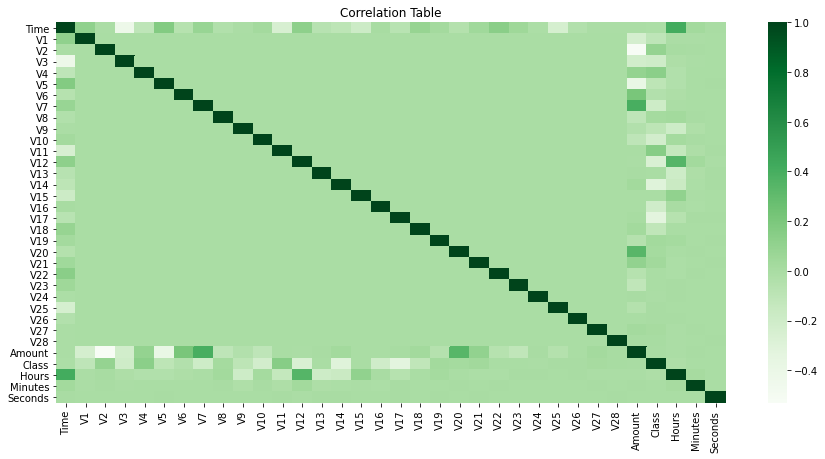

In [ ]:
plt.figure(figsize=(15,7))
sns.heatmap(df.corr(), cmap='Greens')
plt.title('Correlation Table')
plt.show()

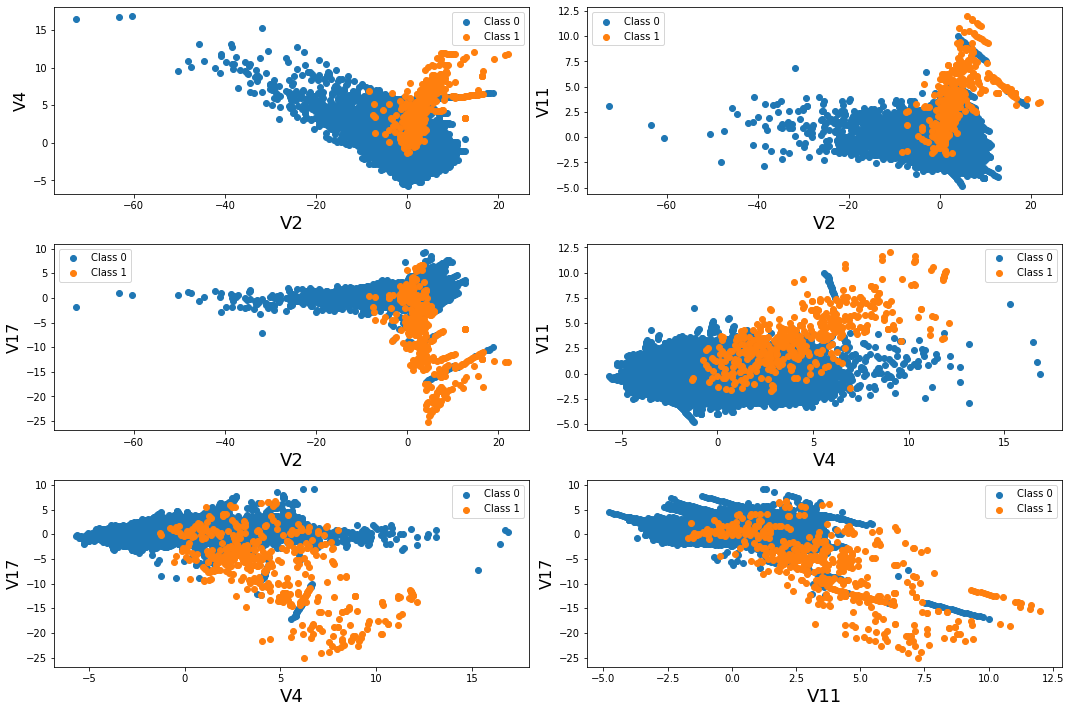

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(15, 10))
axes = axes.flatten()
cols = ['V2','V4','V11','V17']
cols = list(combinations(cols,2 ))

for ax, (cola, colb) in zip(axes, cols):
  ax.scatter(df.loc[df['Class']==0, cola], df.loc[df['Class']==0, colb], label='Class 0')
  ax.scatter(df.loc[df['Class']==1, cola], df.loc[df['Class']==1, colb], label='Class 1')
  ax.set_xlabel(cola, fontsize=18)
  ax.set_ylabel(colb, fontsize=16)
  ax.legend()
plt.tight_layout()
plt.show()

for a,b in cols:
  df[f'{a}_to_{b}'] = df[a] / df[b]

# It seems calculating ratio of features on the plots may contribute to accuracy score.

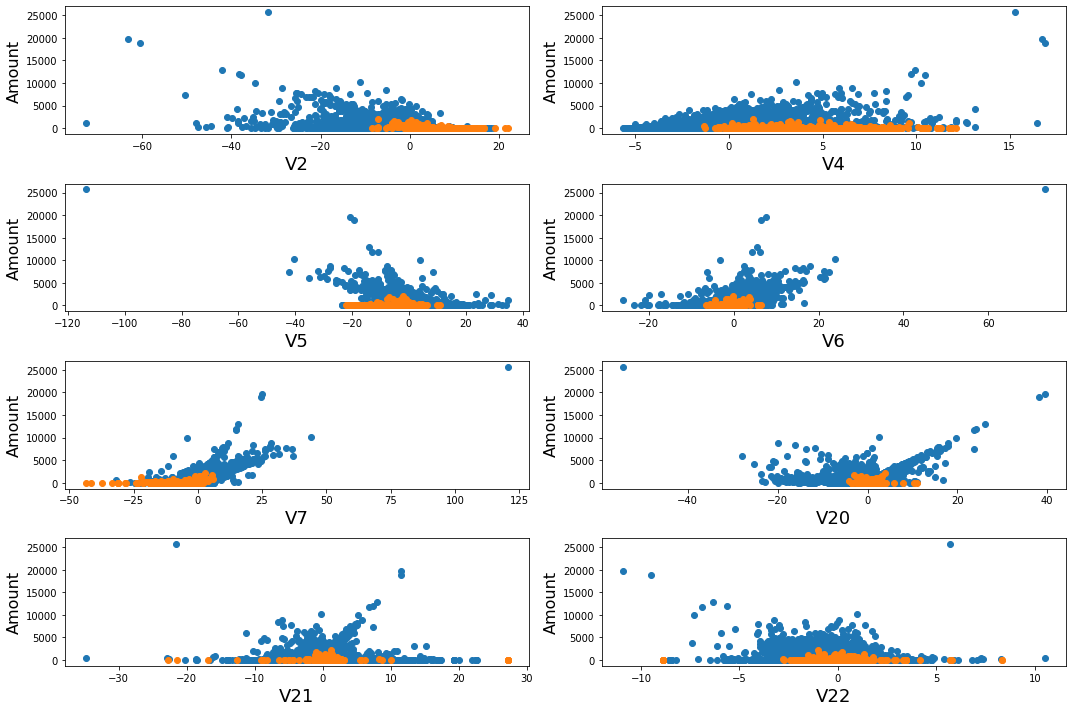

In [ ]:
fig, axes = plt.subplots(4, 2, figsize=(15, 10))
axes = axes.flatten()
cols = ['V2','V4','V5','V6','V7','V20','V21','V22']
for ax, col in zip(axes, cols):
  ax.scatter(df.loc[df['Class']==0, col], df.loc[df['Class']==0, 'Amount'], label='Class 0')
  ax.scatter(df.loc[df['Class']==1, col], df.loc[df['Class']==1, 'Amount'], label='Class 0')
  ax.set_xlabel(col, fontsize=18)
  ax.set_ylabel('Amount', fontsize=16)
plt.tight_layout()
plt.show()

for c in cols:
  df[f'Amount_to_{c}'] = df['Amount'] / df[c]

# We can see that most of the fraud examples concentrate on small area or narrow line
# Calculating ratio of Amount/columns may contribute to accuracy score.

##### Basic Sampler Function

1.   Basic Sampler function for faster hyperparamter optimization



In [ ]:
def sampler(df, rate=10):
  POS = df[df['Class'] == 1]
  NEG = df[df['Class'] == 0].sample(POS.shape[0] * 10)
  return pd.concat([POS, NEG])

USE_FEATS = ['V2','V4','V5','V6','V7','V11','V20','V21','V22','Amount','Hours','V2_to_V4','V2_to_V11',
             'V2_to_V17','V4_to_V11','V4_to_V17','V11_to_V17','Amount_to_V2','Amount_to_V4','Amount_to_V5',
             'Amount_to_V6','Amount_to_V7','Amount_to_V20','Amount_to_V21','Amount_to_V22']

sampled_df = sampler(df)

##### K-Neighbors Classifier

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   44.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 240 out of 240 | elapsed:  4.6min finished


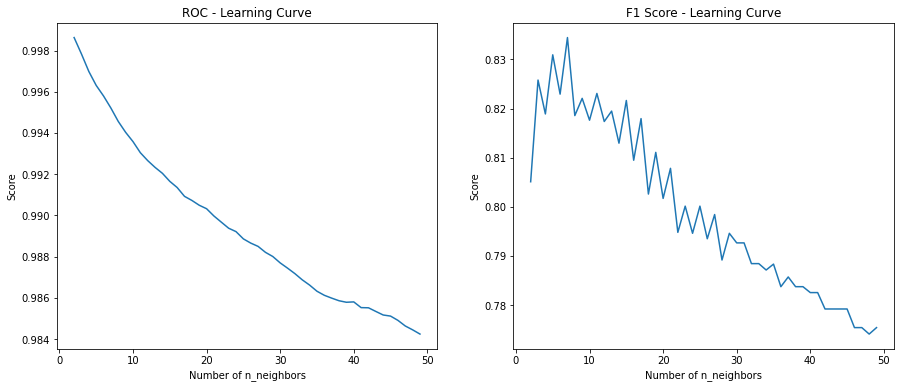

In [ ]:
n_neighbors = range(2,50)

parameters = {'n_neighbors':n_neighbors}

scoring = {'AUC': 'roc_auc', 'F1_Score': make_scorer(f1_score)}

clf_KNN = GridSearchCV(KNeighborsClassifier(), 
                       parameters, 
                       verbose=1, 
                       n_jobs=cpu_count, 
                       scoring=scoring,
                       return_train_score=True,
                       refit='AUC')

X = StandardScaler().fit_transform(sampled_df[USE_FEATS])
y = sampled_df['Class']

results = clf_KNN.fit(X, y)

fig, axes = plt.subplots(1, 2, figsize=(15,6))
axes = axes.flatten()
axes[0].plot(n_neighbors, results.cv_results_['mean_train_AUC'],     label='ROC')
axes[0].set_xlabel('Number of n_neighbors', fontsize=10)
axes[0].set_ylabel('Score', fontsize=10)
axes[0].set_title('ROC - Learning Curve')

axes[1].plot(n_neighbors, results.cv_results_['mean_test_F1_Score'], label='F1 Score')
axes[1].set_xlabel('Number of n_neighbors', fontsize=10)
axes[1].set_ylabel('Score', fontsize=10)
axes[1].set_title('F1 Score - Learning Curve')

plt.show()

##### SVM

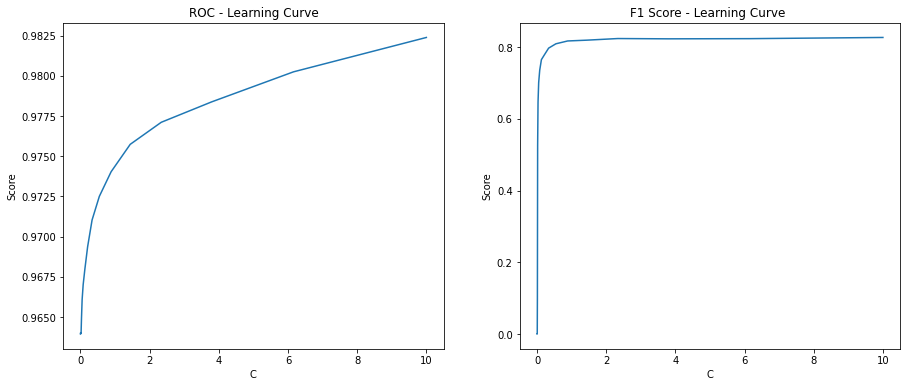

In [ ]:
C = np.logspace(-3, 1, 20)
parameters = {'C':C}

scoring = {'AUC': 'roc_auc', 'F1_Score': make_scorer(f1_score)}

clf_SVM = GridSearchCV(SVC(), 
                       parameters, 
                       verbose=0, 
                       n_jobs=cpu_count, 
                       scoring=scoring, 
                       return_train_score=True,
                       refit='AUC')


X = StandardScaler().fit_transform(sampled_df[USE_FEATS])
y = sampled_df['Class']

results = clf_SVM.fit(X, y)

fig, axes = plt.subplots(1, 2, figsize=(15,6))
axes = axes.flatten()
axes[0].plot(C, results.cv_results_['mean_train_AUC'],     label='ROC')
axes[0].set_xlabel('C', fontsize=10)
axes[0].set_ylabel('Score', fontsize=10)
axes[0].set_title('ROC - Learning Curve')

axes[1].plot(C, results.cv_results_['mean_test_F1_Score'], label='F1 Score')
axes[1].set_xlabel('C', fontsize=10)
axes[1].set_ylabel('Score', fontsize=10)
axes[1].set_title('F1 Score - Learning Curve ')

plt.show()

##### Isolation Forest

Fitting 5 folds for each of 29 candidates, totalling 145 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   33.1s
[Parallel(n_jobs=4)]: Done 145 out of 145 | elapsed:  5.7min finished


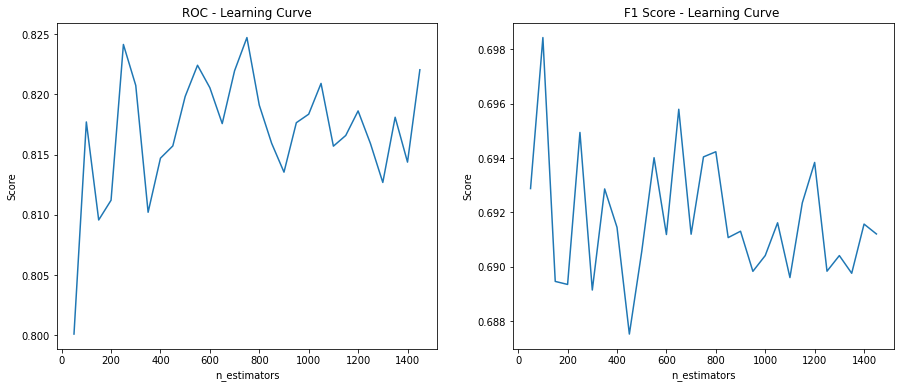

In [ ]:
n_estimators = range(50, 1500, 50)

parameters = {'n_estimators'  : n_estimators,
              'contamination' : [0.5],
              'max_features'  :[10], 
              'bootstrap'     :[True]}

scoring = {'AUC': 'roc_auc', 'F1_Score': make_scorer(f1_score)}

clf_IF = GridSearchCV(IsolationForest(), 
                      parameters, 
                      verbose=1, 
                      n_jobs=cpu_count, 
                      scoring=scoring, 
                      return_train_score=True,
                      refit='AUC',
                      cv=StratifiedKFold())

X = sampled_df[USE_FEATS]
y = sampled_df['Class'].replace(1,-1).replace(0,1)

results = clf_IF.fit(X, y)

fig, axes = plt.subplots(1, 2, figsize=(15,6))
axes = axes.flatten()
axes[0].plot(n_estimators, results.cv_results_['mean_train_AUC'],     label='ROC')
axes[0].set_xlabel('n_estimators', fontsize=10)
axes[0].set_ylabel('Score', fontsize=10)
axes[0].set_title('ROC - Learning Curve')

axes[1].plot(n_estimators, results.cv_results_['mean_test_F1_Score'], label='F1 Score')
axes[1].set_xlabel('n_estimators', fontsize=10)
axes[1].set_ylabel('Score', fontsize=10)
axes[1].set_title('F1 Score - Learning Curve ')

plt.show()

In [ ]:
df['isolatin_forest'] = clf_IF.best_estimator_.predict(df[USE_FEATS])
sampled_df['isolatin_forest'] = clf_IF.best_estimator_.predict(sampled_df[USE_FEATS])

In [ ]:
params = { 
          'num_leaves' : [10, 15, 20, 25],
          'lambda_l1'  : [.01, .1 , 1],
          'lambda_l2'  : [.01, .1 , 1]

          }

clf_lgb = lgb.LGBMClassifier(boosting_type='gbdt', 
                             objective='binary',
                             metric='None', 
                             random_state=111, 
                             silent=1, 
                             learning_rate=0.001,
                             n_estimators=1000)

gs_lgb = GridSearchCV(clf_lgb, 
                      params, 
                      scoring='roc_auc', 
                      cv=StratifiedKFold(), 
                      refit=True, 
                      verbose=True, 
                      n_jobs=cpu_count)

gs_lgb.fit(sampled_df.drop('Class', axis=1), sampled_df['Class'])

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:  5.4min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             error_score=nan,
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.001, max_depth=-1,
                                      metric='None', min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=1000,
                                      n_jobs=-1, num_leaves=31,
                                      objective='binary', random_state=111,
                                      reg_alpha=0.0, reg_lambda=0.0, silent=1,
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='deprecated', n_jobs=4,
      

In [ ]:
print('Best Parameters : ', gs_lgb.best_params_)

Best Parameters :  {'lambda_l1': 0.01, 'lambda_l2': 1, 'num_leaves': 20, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc'}


In [ ]:
skf = StratifiedKFold(n_splits=6).split(df, df['Class'])

X = df.drop('Class', axis=1)
y = df['Class']

eval_results = dict()
for i, (train_idx, test_idx) in enumerate(skf):
  eval_results[f'FOLD_{i}'] = {}
  X_train, y_train = X.iloc[train_idx, :], y[train_idx]
  X_test,  y_test  = X.iloc[test_idx, :],  y[test_idx]
  
  train_lgb = lgb.Dataset(X_train, y_train)
  valid_lgb = lgb.Dataset(X_test,  y_test, reference=train_lgb)

  params = gs_lgb.best_params_
  params.update({'boosting_type':'gbdt',
                 'objective':'binary',
                 'metric':'auc',
                 'is_unbalance':True
                })
  gbm = lgb.train(params, 
                   train_lgb, 
                   num_boost_round=10000,
                   learning_rates  = lambda x: 0.001 * .99**x, 
                   valid_sets=[train_lgb,valid_lgb],
                   verbose_eval=100,
                   early_stopping_rounds=1000,
                   evals_result=eval_results[f'FOLD_{i}']
                  )
  eval_results[f'MODEL_{i}'] = gbm    

Training until validation scores don't improve for 1000 rounds.
[100]	training's auc: 0.99823	valid_1's auc: 0.988621
[200]	training's auc: 0.998329	valid_1's auc: 0.988686
[300]	training's auc: 0.998366	valid_1's auc: 0.988538
[400]	training's auc: 0.998371	valid_1's auc: 0.988498
[500]	training's auc: 0.998372	valid_1's auc: 0.988483
[600]	training's auc: 0.998373	valid_1's auc: 0.988472
[700]	training's auc: 0.998373	valid_1's auc: 0.98847
[800]	training's auc: 0.998373	valid_1's auc: 0.988469
[900]	training's auc: 0.998373	valid_1's auc: 0.988469
[1000]	training's auc: 0.998373	valid_1's auc: 0.988469
Early stopping, best iteration is:
[33]	training's auc: 0.997505	valid_1's auc: 0.99141
Training until validation scores don't improve for 1000 rounds.
[100]	training's auc: 0.998462	valid_1's auc: 0.978298
[200]	training's auc: 0.998779	valid_1's auc: 0.978783
[300]	training's auc: 0.998807	valid_1's auc: 0.978687
[400]	training's auc: 0.998811	valid_1's auc: 0.97866
[500]	training's

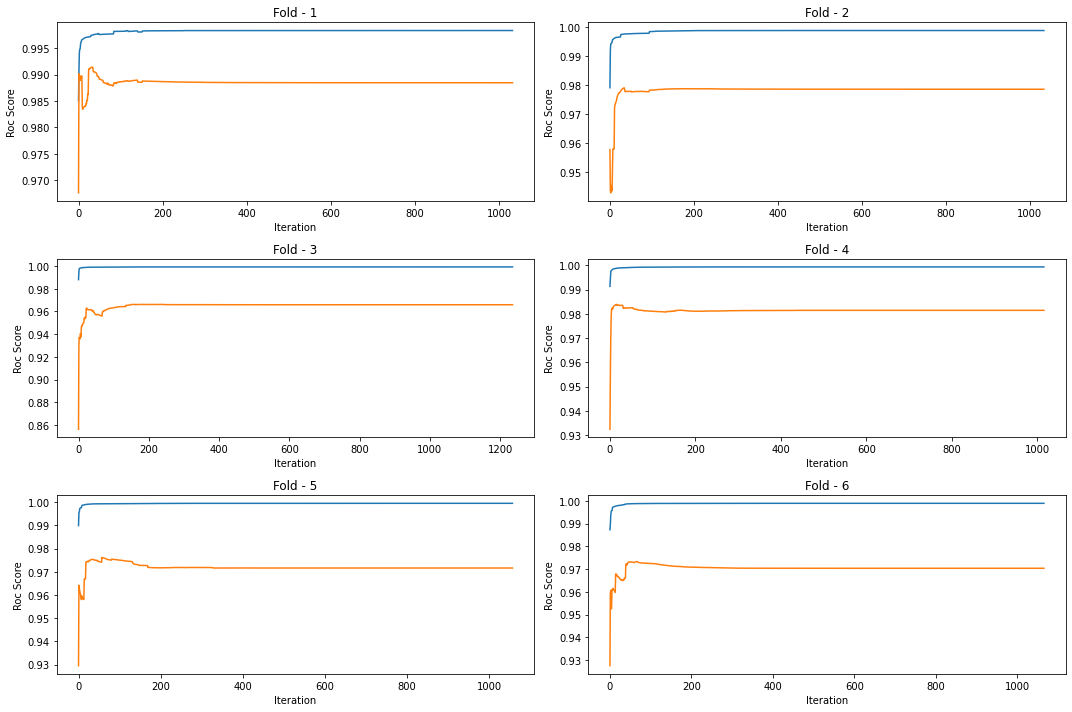

In [ ]:
training_eval = [eval_results[i]['training']['auc'] for i in eval_results if 'FOLD' in i]
valid_eval    = [eval_results[i]['valid_1']['auc'] for i in eval_results if 'FOLD' in i]

fig, axes = plt.subplots(3, 2, figsize=(15, 10))
axes = axes.flatten()
for idx, ax in enumerate(axes):
  ax.plot(training_eval[idx])
  ax.plot(valid_eval[idx])
  ax.set_title(f'Fold - {idx+1}')
  ax.set_xlabel('Iteration')
  ax.set_ylabel('Roc Score')
plt.tight_layout()
plt.show()

In [ ]:
feat_importance = pd.DataFrame()
for idx, model in enumerate([eval_results[i] for i in eval_results if 'MODEL' in i]):
  df[f'Fold_{idx}'] = model.predict(X)
  tmp = pd.DataFrame(model.feature_importance(), index=model.feature_name()).T
  feat_importance = feat_importance.append(tmp)

df['AvgPred'] = df[[e for e in df if 'Fold_' in e]].mean(axis=1)
feat_importance = feat_importance.mean(axis=0).rename('Importance').reset_index().sort_values('Importance', ascending=False)

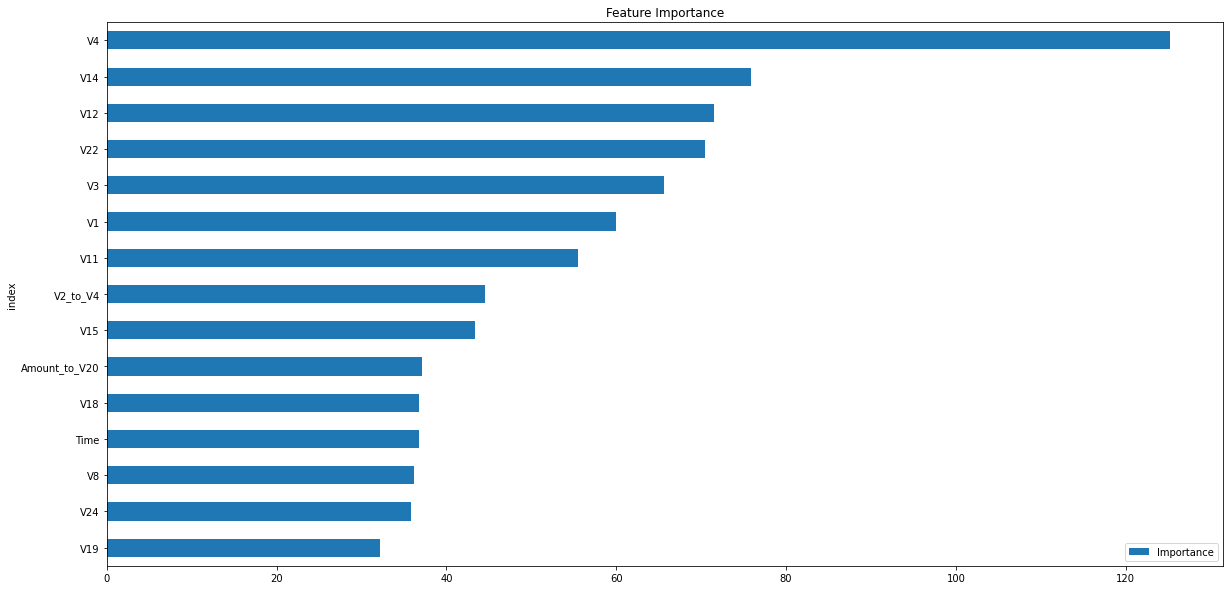

In [ ]:
feat_importance.head(15).sort_values('Importance').plot.barh('index', 'Importance', title='Feature Importance', figsize=(20,10))
plt.show()

In [ ]:
thresholds = np.linspace(0,df['AvgPred'].round(2).max(),50)
tn_lst = list() 
fp_lst = list()
fn_lst = list() 
tp_lst = list()
f1_score_lst = list()
for i in thresholds:
  tn, fp, fn, tp  = confusion_matrix(df['Class'], df['AvgPred'].apply(lambda x: 1 if x>i else 0)).ravel()
  tn_lst.append(tn)
  fp_lst.append(fp)
  fn_lst.append(fn)
  tp_lst.append(tp)
  f1_score_lst.append(f1_score(df['Class'], df['AvgPred'].apply(lambda x: 1 if x>i else 0)))

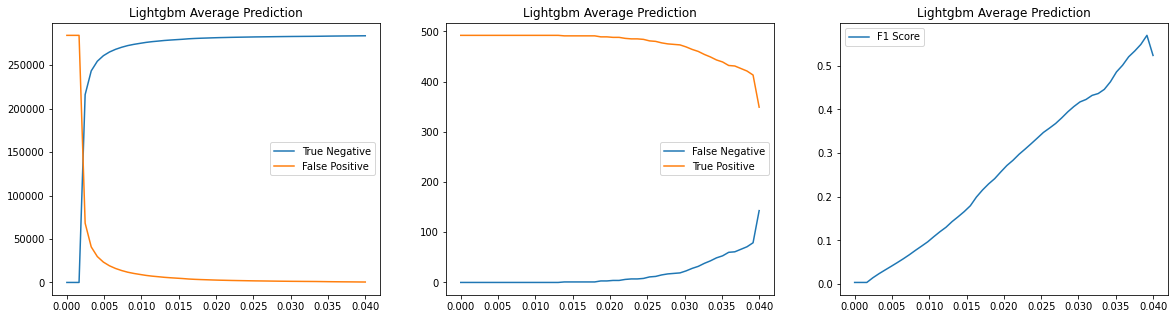

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(20,5))
ax = ax.flatten()
ax[0].plot(thresholds, tn_lst, label='True Negative')
ax[0].plot(thresholds, fp_lst, label='False Positive')
ax[0].set_title('Lightgbm Average Prediction')
ax[0].legend()

ax[1].plot(thresholds, fn_lst, label='False Negative')
ax[1].plot(thresholds, tp_lst, label='True Positive')
ax[1].set_title('Lightgbm Average Prediction')
ax[1].legend()

ax[2].plot(thresholds, f1_score_lst, label='F1 Score')
ax[2].set_title('Lightgbm Average Prediction')
ax[2].legend()
plt.show()